# Implementation of QAOA

### getting portfolio

[*********************100%***********************]  3 of 3 completed


{'bitstring': '001110001', 'risk': np.float64(5.774062499999999), 'volatility': np.float64(2.402927901540119), 'allocations': {0: 0.125, 1: 0.75, 2: 0.125}, 'total_allocation': 1.0, 'count': 6}
GLD: 12.50%
NVDA: 75.00%
^GSPC: 12.50%
{'bitstring': '010100010', 'risk': np.float64(3.12425), 'volatility': np.float64(1.7675548082025632), 'allocations': {0: 0.25, 1: 0.5, 2: 0.25}, 'total_allocation': 1.0, 'count': 5}
GLD: 25.00%
NVDA: 50.00%
^GSPC: 25.00%
{'bitstring': '101000011', 'risk': np.float64(0.7769999999999999), 'volatility': np.float64(0.8814760348415605), 'allocations': {0: 0.375, 1: 0.0, 2: 0.625}, 'total_allocation': 1.0, 'count': 4}
GLD: 37.50%
NVDA: 0.00%
^GSPC: 62.50%
{'bitstring': '001000111', 'risk': np.float64(0.9750000000000001), 'volatility': np.float64(0.987420882906575), 'allocations': {0: 0.875, 1: 0.0, 2: 0.125}, 'total_allocation': 1.0, 'count': 3}
GLD: 87.50%
NVDA: 0.00%
^GSPC: 12.50%
{'bitstring': '001100011', 'risk': np.float64(2.886), 'volatility': np.float64(1.

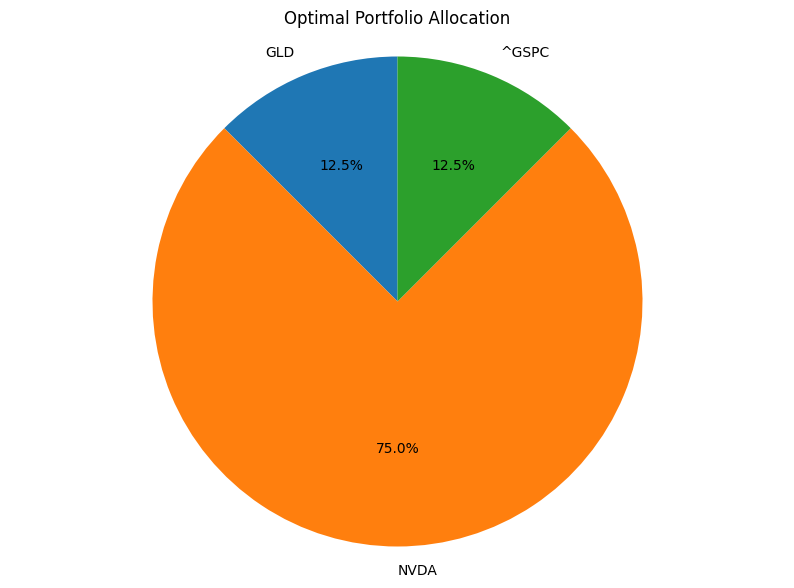

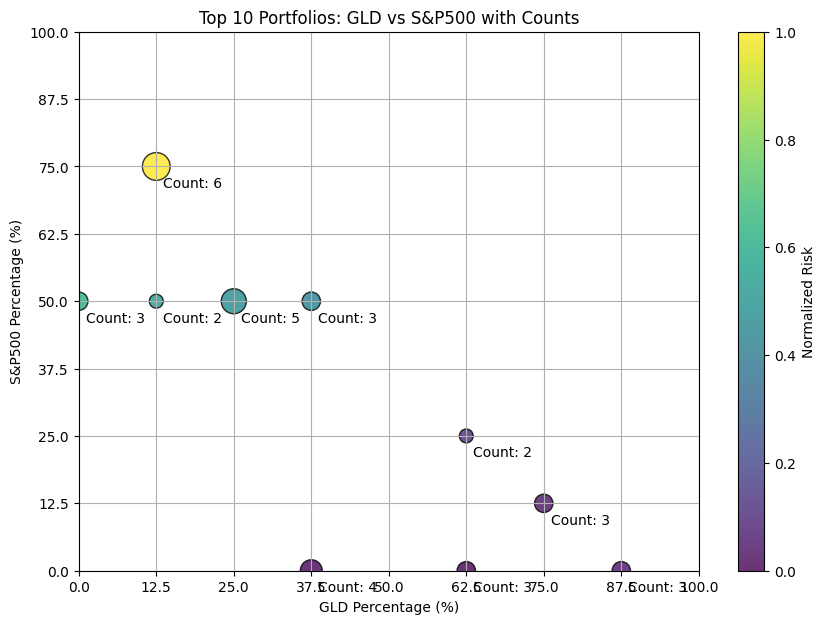

In [28]:
import yfinance as yf
import pandas as pd

import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from collections import defaultdict
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

tickers = ['GLD', '^GSPC']
data = yf.download(tickers, start='2005-01-01', end='2025-01-01')

close_prices = data['Close']
daily_returns = close_prices.pct_change().dropna()*100 #  ( Pt − Pt-1 ) / Pt−1

# Mean daily return for each asset
# Convert to list for your QUBO code
returns_list = daily_returns.mean().to_numpy().tolist()
returns_list

cov_stocks=daily_returns.cov()

cov_matrix = cov_stocks.round(3).to_numpy()

# Define tickers for readability
tickers = ['BAC', 'GS', 'JPM', 'MS']
tickers = list(cov_stocks.index)

# Define the number of assets
n_assets = len(tickers)

# Define the number of binary variables per asset
# This determines the granularity of allocation (e.g., 3 bits = 8 levels)
bits_per_asset = 3

# Define budget constraint (e.g., total allocation = 100%)
budget = 1.0

# Define lambda parameter for constraints
lambd = 10.0  # Adjust based on the importance of constraints

def construct_portfolio_qubo(cov_matrix, n_assets, bits_per_asset, budget, returns, return_coeff, lambd):
    """
    Construct the QUBO matrix for portfolio optimization.
    
    Parameters:
    - cov_matrix: Covariance matrix of assets
    - n_assets: Number of assets
    - bits_per_asset: Number of binary variables per asset
    - budget: Total budget constraint (usually 1.0 for 100%)
    - lambd: Penalty parameter for constraints
    
    Returns:
    - Q: QUBO matrix
    """
    total_qubits = n_assets * bits_per_asset
    Q = np.zeros((total_qubits, total_qubits))
    
    # Define the weights for binary encoding (e.g., [0.125, 0.25, 0.5] for 3 bits)
    weights = [2**(-i-1) for i in range(bits_per_asset)][::-1]
    
    # Objective function: minimize portfolio variance
    for i in range(n_assets):
        for j in range(n_assets):
            for bi in range(bits_per_asset):
                for bj in range(bits_per_asset):
                    # Index in the Q matrix
                    idx_i = i * bits_per_asset + bi
                    idx_j = j * bits_per_asset + bj
                    
                    # Weight of this binary variable combination
                    weight_i = weights[bi]
                    weight_j = weights[bj]
                    
                    # Add to QUBO matrix (objective is to minimize risk)
                    Q[idx_i, idx_j] += cov_matrix[i, j] * weight_i * weight_j
    
    # Budget constraint: sum of all allocations should equal budget
    # We add a penalty term: λ(sum(weights*x) - budget)^2
    
    # First, expand the squared term
    # (sum(weights*x) - budget)^2 = (sum(weights*x))^2 - 2*budget*sum(weights*x) + budget^2
    
    # The budget^2 term is constant and can be ignored
    
    # For the (sum(weights*x))^2 term:
    for i in range(n_assets):
        for bi in range(bits_per_asset):
            for j in range(n_assets):
                for bj in range(bits_per_asset):
                    idx_i = i * bits_per_asset + bi
                    idx_j = j * bits_per_asset + bj
                    weight_i = weights[bi]
                    weight_j = weights[bj]
                    Q[idx_i, idx_j] += lambd * weight_i * weight_j
    
    # For the -2*budget*sum(weights*x) term and return maximization:
    for i in range(n_assets):
        for bi in range(bits_per_asset):
            idx = i * bits_per_asset + bi
            weight = weights[bi]
            Q[idx, idx] -= 2 * lambd * budget * weight

            # Subtract because we want to maximize return
            Q[idx, idx] -= return_coeff * returns[i] * weight        
    
    return Q

# -----------------------------   QAOA circuit ------------------------------------
def qaoa_circuit(gammas, betas, h, J, num_qubits):
    """
    Create a QAOA circuit in Qiskit.
    
    Parameters:
    - gammas: Parameters for the cost Hamiltonian
    - betas: Parameters for the mixer Hamiltonian
    - h: Dictionary of single-qubit terms
    - J: Dictionary of two-qubit interaction terms
    - num_qubits: Number of qubits in the circuit
    
    Returns:
    - qc: Quantum circuit implementing QAOA
    """
    p = len(gammas)
    wmax = max(
        np.max(np.abs(list(h.values()))), np.max(np.abs(list(J.values())))
    )  # Normalizing the Hamiltonian
    
    # Create a quantum circuit with num_qubits qubits
    qc = QuantumCircuit(num_qubits, num_qubits)
    
    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        qc.h(i)
    
    # Repeat p layers of the QAOA circuit
    for layer in range(p):
        # ---------- COST HAMILTONIAN ----------
        for ki, v in h.items():  # single-qubit terms
            qc.rz(2 * gammas[layer] * v / wmax, ki[0])
        
        for kij, vij in J.items():  # two-qubit terms
            qc.cx(kij[0], kij[1])
            qc.rz(2 * gammas[layer] * vij / wmax, kij[1])
            qc.cx(kij[0], kij[1])
        
        # ---------- MIXER HAMILTONIAN ----------
        for i in range(num_qubits):
            qc.rx(-2 * betas[layer], i)
    
    # Measure all qubits
    qc.measure(range(num_qubits), range(num_qubits))
    
    return qc

def from_Q_to_Ising(Q, offset):
    """
    Convert the QUBO matrix Q into Ising model parameters.
    
    Parameters:
    - Q: QUBO matrix
    - offset: Initial offset value
    
    Returns:
    - h: Dictionary of single-qubit terms
    - J: Dictionary of two-qubit interaction terms
    - offset: Updated offset value
    """
    n_qubits = len(Q)
    h = defaultdict(int)
    J = defaultdict(int)
    
    for i in range(n_qubits):
        h[(i,)] -= Q[i, i] / 2
        offset += Q[i, i] / 2
        
        for j in range(i + 1, n_qubits):
            J[(i, j)] += Q[i, j] / 4
            h[(i,)] -= Q[i, j] / 4
            h[(j,)] -= Q[i, j] / 4
            offset += Q[i, j] / 4
            
    return h, J, offset

# Construct the QUBO matrix
Q = construct_portfolio_qubo(cov_matrix, n_assets, bits_per_asset, budget, returns_list, 2, lambd)
#print(Q)

# Use the existing from_Q_to_Ising function
offset = 0  # We can start with zero offset
h, J, offset = from_Q_to_Ising(Q, offset)

# Define QAOA parameters
p = 5  # Number of QAOA layers
gammas = np.linspace(0.1, 1.0, p)  # Parameters for cost Hamiltonian
betas = np.linspace(0.1, 0.8, p)[::-1]  # Parameters for mixer Hamiltonian
total_qubits = n_assets * bits_per_asset
# Create the QAOA circuit
qc = qaoa_circuit(gammas, betas, h, J, total_qubits)

# Run the circuit
simulator = AerSimulator()
result = simulator.run(qc, shots=10000).result()
result_counts = result.get_counts()

def decode_portfolio_allocation(bitstring, n_assets, bits_per_asset):
    """
    Decode a bitstring into portfolio allocations.
    
    Parameters:
    - bitstring: Binary string from measurement
    - n_assets: Number of assets
    - bits_per_asset: Number of binary variables per asset
    
    Returns:
    - allocations: Dictionary mapping asset indices to allocation percentages
    """
    # Reverse the bitstring to match the expected format
    bitstring = bitstring[::-1]
    
    allocations = {}
    weights = [2**(-i-1) for i in range(bits_per_asset)][::-1]
    
    for i in range(n_assets):
        asset_bits = bitstring[i*bits_per_asset:(i+1)*bits_per_asset]
        allocation = sum(int(bit) * weight for bit, weight in zip(asset_bits, weights))
        allocations[i] = allocation
    
    return allocations

def calculate_portfolio_risk(allocations, cov_matrix):
    """
    Calculate the portfolio risk given allocations.
    
    Parameters:
    - allocations: Dictionary mapping asset indices to allocation percentages
    - cov_matrix: Covariance matrix of assets
    
    Returns:
    - risk: Portfolio risk (variance)
    """
    alloc_vector = np.zeros(len(cov_matrix))
    for idx, alloc in allocations.items():
        alloc_vector[idx] = alloc
    
    risk = alloc_vector.T @ cov_matrix @ alloc_vector
    return risk

def valid_top_portfolios_infos(counts, n_assets, bits_per_asset, cov_matrix, tickers, budget=1.0, top_n=3):
    """
    Returns:
    - top_portfolios: List of dictionaries containing portfolio information
    """
    # Store information about all valid portfolios
    all_portfolios = []
    
    for bitstring, count in counts.items():
        # Decode the bitstring into portfolio allocations
        allocations = decode_portfolio_allocation(bitstring, n_assets, bits_per_asset)
        
        # Calculate the total allocation
        total_allocation = sum(allocations.values())
        
        # Check if the allocation is close to the budget constraint
        if abs(total_allocation - budget) < 0.1:  # Allow some tolerance (±10%)
            # Calculate portfolio risk
            risk = calculate_portfolio_risk(allocations, cov_matrix)
            
            # Create a dictionary with portfolio information
            portfolio_info = {
                'bitstring': bitstring,
                'risk': risk,
                'volatility': np.sqrt(risk),
                'allocations': allocations,
                'total_allocation': total_allocation,
                'count': count  # How many times this solution appeared
            }
            
            all_portfolios.append(portfolio_info)
    
    # Sort portfolios by risk (ascending)
    all_portfolios.sort(key=lambda x: x['count'], reverse=True)
    
    # Take the top N portfolios
    top_portfolios = all_portfolios[:top_n]
    
    return top_portfolios

valid_p = valid_top_portfolios_infos(result_counts, n_assets, bits_per_asset, cov_matrix, tickers, top_n=10)
for x in valid_p:
    print(x)
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {x['allocations'].get(i, 0) * 100:.2f}%")

valid_p[0]['allocations']



def plot_portfolio_allocation(allocations, tickers):
    """
    Plot the portfolio allocation as a pie chart.
    
    Parameters:
    - allocations: Dictionary mapping asset indices to allocation percentages
    - tickers: List of ticker symbols
    """
    labels = []
    sizes = []
    
    for i, ticker in enumerate(tickers):
        alloc = allocations.get(i, 0)
        if alloc > 0:
            labels.append(ticker)
            sizes.append(alloc)
    
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Optimal Portfolio Allocation')
    plt.show()

# Plot the best allocation
plot_portfolio_allocation(valid_p[0]['allocations'], tickers)


# plotting
x = [p['allocations'].get(0, 0) * 100 for p in valid_p]  # GLD %
y = [p['allocations'].get(1, 0) * 100 for p in valid_p]  # ^GSPC %
risk = [p['risk'] for p in valid_p]
counts = [p['count'] for p in valid_p]

# Normalize risk for color mapping
norm_risk = (np.array(risk) - min(risk)) / (max(risk) - min(risk))

# Normalize counts for size mapping
norm_counts = (np.array(counts) - min(counts)) / (max(counts) - min(counts))

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=norm_risk, s=100 + norm_counts * 300, cmap='viridis', alpha=0.8, edgecolors='black')

# Add colorbar for risk
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Risk')

# Labels and title
plt.xlabel('GLD Percentage (%)')
plt.ylabel('S&P500 Percentage (%)')
plt.title(f"Top {len(valid_p)} Portfolios: GLD vs S&P500 with Counts")

# Set x and y axis limits and ticks
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 101, 12.5))
plt.yticks(np.arange(0, 101, 12.5))

# Annotate points with risk and count
for i, p in enumerate(valid_p):
    plt.annotate(f"Count: {p['count']}", (x[i], y[i]), textcoords="offset points", xytext=(5,-15), ha='left')

plt.grid(True)
plt.show()

In [23]:
counts

[30, 27, 24, 24, 22, 20, 17]

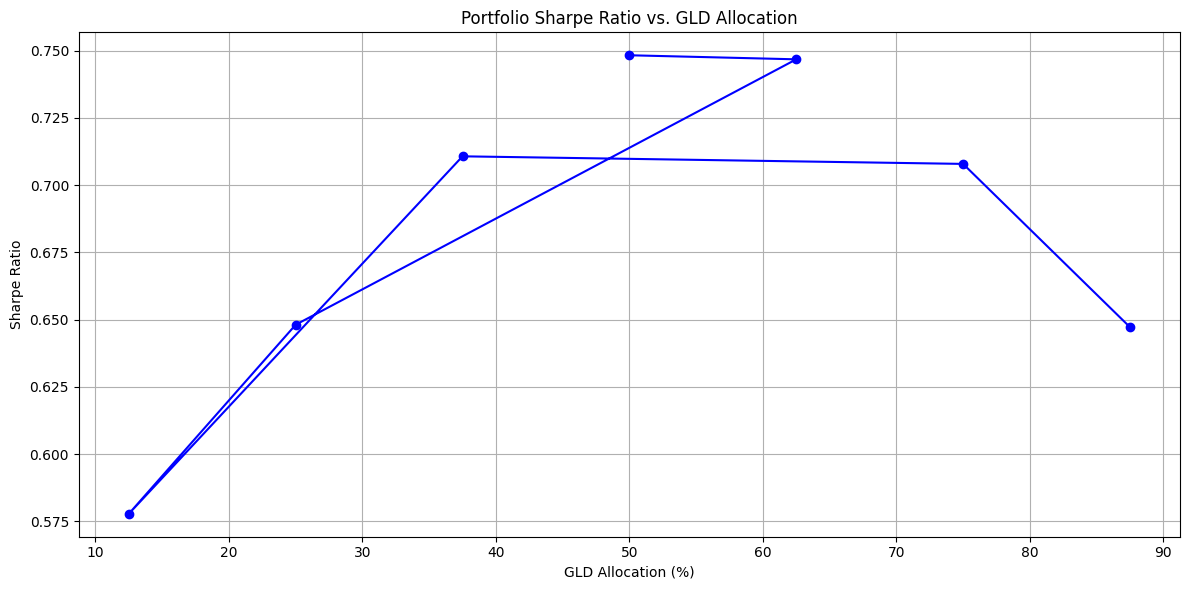

In [25]:
import scipy.stats as st
def plot_sharpe_ratio(counts, n_assets, bits_per_asset, cov_matrix, returns_list, tickers, budget=1.0, top_n=10):
    """
    Plots a graph of portfolio allocations vs. Sharpe Ratio for the top N portfolios.
    
    Parameters:
    - counts: Counts dictionary from QAOA execution
    - n_assets: Number of assets
    - bits_per_asset: Number of bits per asset
    - cov_matrix: Covariance matrix of assets
    - returns_list: List of mean daily returns for each asset
    - tickers: List of ticker symbols
    - budget: Total budget constraint
    - top_n: Number of top portfolios to consider
    """
    
    # Retrieve valid portfolios
    valid_portfolios = valid_top_portfolios_infos(counts, n_assets, bits_per_asset, cov_matrix, tickers, budget, top_n)
    
    # Prepare data for plotting
    sharpe_ratios = []
    gld_allocations = []  # Example: Allocation to GLD
    
    for portfolio in valid_portfolios:
        # Calculate portfolio return
        portfolio_return = sum(portfolio['allocations'][i] * returns_list[i] for i in range(n_assets))
        
        # Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
        sharpe_ratio = (portfolio_return) / portfolio['volatility'] * np.sqrt(252) if portfolio['volatility'] > 0 else 0
        
        sharpe_ratios.append(sharpe_ratio)
        gld_allocations.append(portfolio['allocations'].get(0, 0) * 100)  # GLD allocation in percentage
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(gld_allocations, sharpe_ratios, marker='o', linestyle='-', color='blue')
    plt.title('Portfolio Sharpe Ratio vs. GLD Allocation')
    plt.xlabel('GLD Allocation (%)')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have the variables defined as in your original script)
plot_sharpe_ratio(result_counts, n_assets, bits_per_asset, cov_matrix, returns_list, tickers)

In [26]:
def plot_sharpe_ratio(counts, n_assets, bits_per_asset, cov_matrix, returns_list, tickers, budget=1.0, top_n=10, sort_by_asset='GLD'):
    """
    Calculates and plots a graph of portfolio allocations vs. Sharpe Ratio.
    The portfolios are sorted by the allocation to the specified 'sort_by_asset' before plotting.
    """

    # Retrieve valid portfolios (initially sorted by QAOA counts)
    portfolios_from_qaoa = valid_top_portfolios_infos(counts, n_assets, bits_per_asset, cov_matrix, tickers, budget, top_n)

    if not portfolios_from_qaoa:
        print("No valid portfolios found to plot Sharpe ratio.")
        return

    # Determine the index of the asset to sort by
    sort_asset_index = tickers.index(sort_by_asset)

    # Sort the retrieved portfolios by the allocation to 'sort_by_asset'
    # The key for sorting will be the allocation percentage of the 'sort_by_asset'
    sorted_portfolios = sorted(portfolios_from_qaoa, key=lambda p: p['allocations'].get(sort_asset_index, 0))

    # Prepare data for plotting
    sharpe_ratios_plot = []
    asset_allocations_plot = []  # Allocation to the 'sort_by_asset'

    # Risk-free rate (daily). Assuming 0 for simplicity.
    daily_rf_rate_decimal = 0.0 # This is 0% daily. If returns_list is in %, this should also be in % or convert returns

    for portfolio in sorted_portfolios:
        # Calculate portfolio mean daily return (make sure units are consistent)
        # returns_list is in daily percentage returns (e.g., 0.1 for 0.1%)
        portfolio_mean_daily_return_percent = sum(portfolio['allocations'][i] * returns_list[i] for i in range(n_assets))

        # Portfolio volatility (standard deviation of daily percentage returns)
        # portfolio['volatility'] is already sqrt(variance) of daily percentage returns
        portfolio_daily_volatility_percent = portfolio['volatility']

        # Calculate Sharpe Ratio
        # Sharpe = (Portfolio Return - Risk-Free Rate) / Portfolio Volatility
        # Ensure returns and volatility are in the same units (e.g., decimals or percentages)
        # If returns_list[i] are percentages (e.g., 0.05 for 0.05%), and volatility is also in percentages.
        if portfolio_daily_volatility_percent > 1e-9: # Avoid division by zero or very small numbers
            sharpe_ratio = (portfolio_mean_daily_return_percent - daily_rf_rate_decimal) / portfolio_daily_volatility_percent
        else:
            sharpe_ratio = 0 # Or np.nan, or handle as an edge case

        sharpe_ratios_plot.append(sharpe_ratio)
        asset_allocations_plot.append(portfolio['allocations'].get(sort_asset_index, 0) * 100)  # Allocation in percentage

    # Annualize Sharpe Ratio for better interpretation (optional, but common)
    # Multiply daily Sharpe ratio by sqrt(252) (approx. number of trading days in a year)
    annualized_sharpe_ratios_plot = [s * np.sqrt(252) for s in sharpe_ratios_plot]

    # Plotting (using annualized Sharpe Ratios)
    plt.figure(figsize=(12, 7))
    plt.plot(asset_allocations_plot, annualized_sharpe_ratios_plot, marker='o', linestyle='-', color='teal')
    
    # Annotate points with the annualized Sharpe ratio value
    for i, txt in enumerate(annualized_sharpe_ratios_plot):
        plt.annotate(f"{txt:.2f}", (asset_allocations_plot[i], annualized_sharpe_ratios_plot[i]),
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

    plt.title(f'Annualized Sharpe Ratio vs. {sort_by_asset} Allocation (Top {len(sorted_portfolios)} QAOA Portfolios)')
    plt.xlabel(f'{sort_by_asset} Allocation (%)')
    plt.ylabel('Annualized Sharpe Ratio')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\nData for Sharpe Ratio plot (sorted by {sort_by_asset} allocation):")
    print(f"{sort_by_asset} Allocation (%): {asset_allocations_plot}")
    print(f"Daily Sharpe Ratios: {[f'{s:.4f}' for s in sharpe_ratios_plot]}")
    print(f"Annualized Sharpe Ratios: {[f'{s:.3f}' for s in annualized_sharpe_ratios_plot]}")


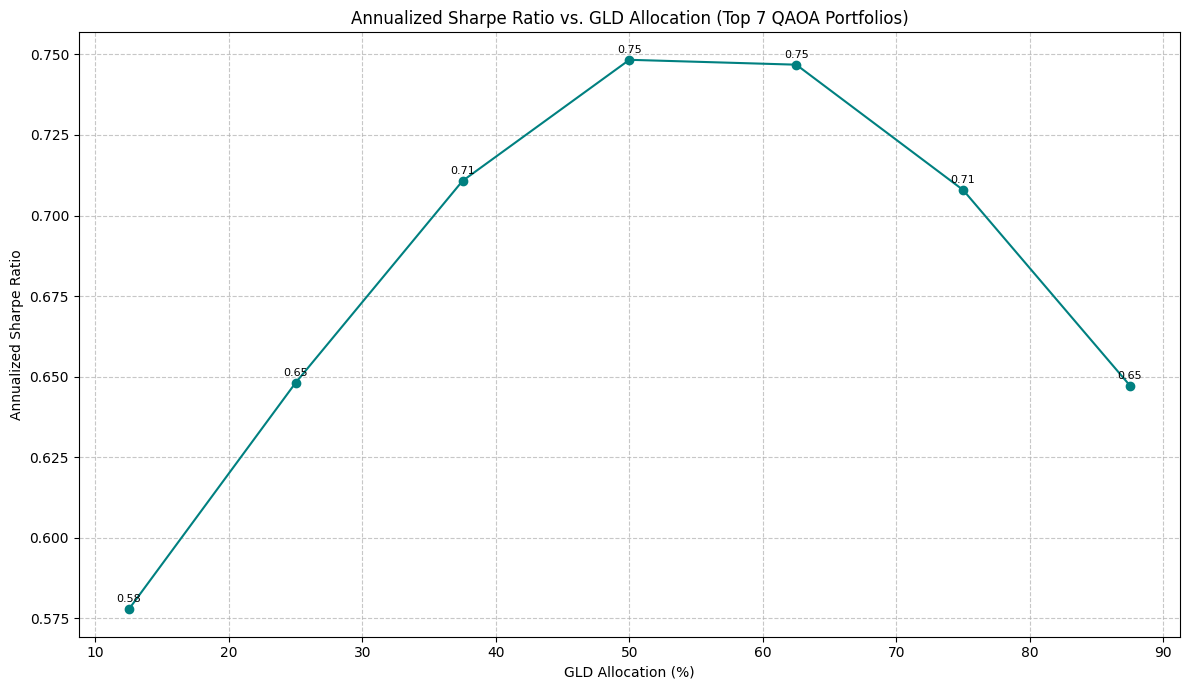


Data for Sharpe Ratio plot (sorted by GLD allocation):
GLD Allocation (%): [12.5, 25.0, 37.5, 50.0, 62.5, 75.0, 87.5]
Daily Sharpe Ratios: ['0.0364', '0.0408', '0.0448', '0.0471', '0.0470', '0.0446', '0.0408']
Annualized Sharpe Ratios: ['0.578', '0.648', '0.711', '0.748', '0.747', '0.708', '0.647']


In [27]:
plot_sharpe_ratio(result_counts, n_assets, bits_per_asset, cov_matrix, returns_list, tickers)

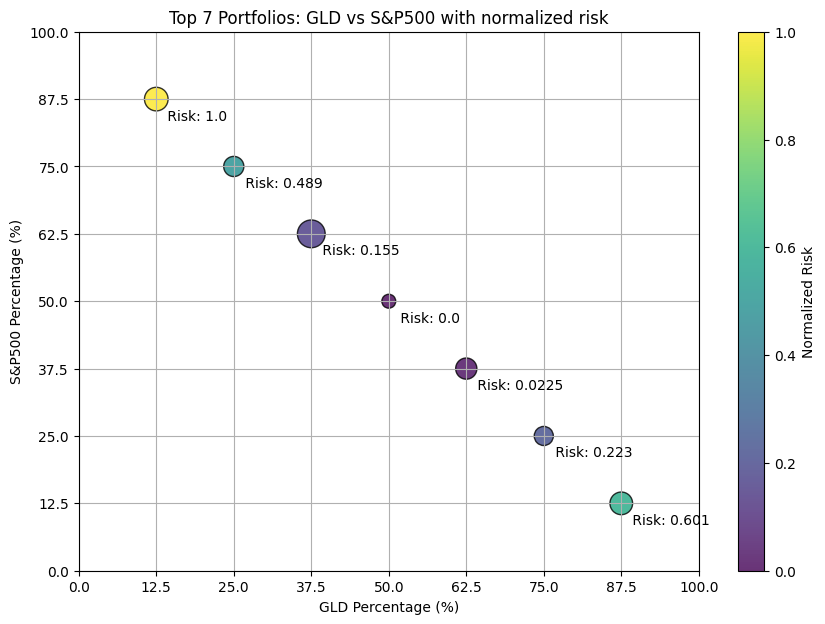

In [19]:
# plotting
x = [p['allocations'].get(0, 0) * 100 for p in valid_p]  # GLD %
y = [p['allocations'].get(1, 0) * 100 for p in valid_p]  # ^GSPC %
risk = [p['risk'] for p in valid_p]
counts = [p['count'] for p in valid_p]

# Normalize risk for color and size mapping
norm_risk = (np.array(risk) - min(risk)) / (max(risk) - min(risk))
norm_counts = (np.array(counts) - min(counts)) / (max(counts) - min(counts))

# sort all arrays by ascending risk
order = np.argsort(risk)
x = np.array(x)[order]
y = np.array(y)[order]
norm_risk = norm_risk[order]
norm_counts = norm_counts[order]
valid_p = [valid_p[i] for i in order]


# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=norm_risk, s=100 + norm_counts * 300, cmap='viridis', alpha=0.8, edgecolors='black')

# Add colorbar for risk
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Risk')

# Labels and title
plt.xlabel('GLD Percentage (%)')
plt.ylabel('S&P500 Percentage (%)')
plt.title(f"Top {len(valid_p)} Portfolios: GLD vs S&P500 with normalized risk")

# Set x and y axis limits and ticks
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 101, 12.5))
plt.yticks(np.arange(0, 101, 12.5))

# Annotate points with risk and count
for i, p in enumerate(valid_p):
    plt.annotate(f" Risk: {norm_risk[i]:.3}", (x[i], y[i]), textcoords="offset points", xytext=(5,-15), ha='left')

plt.grid(True)
plt.show()
